In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import torch
import clip
from PIL import Image

In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset = datasets.ImageFolder(
    root="data/images",
    transform=preprocess
)

# DataLoader for batching
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [8]:
import matplotlib.pyplot as plt


all_embeddings = []
with torch.no_grad():
    for images, _ in dataloader:  # we ignore class labels
        images = images.to(device)
        features = model.encode_image(images)
        features /= features.norm(dim=-1, keepdim=True)
        all_embeddings.append(features)

embeddings = torch.cat(all_embeddings, dim=0)

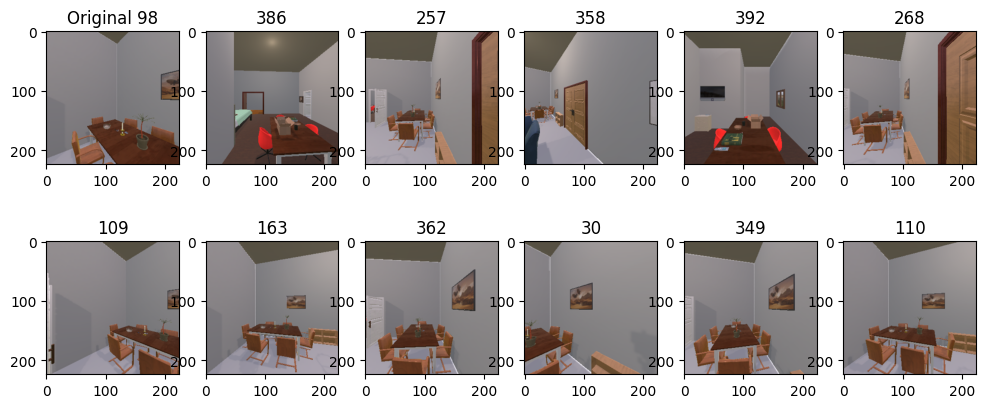

In [ ]:
embeddings_norm = embeddings / torch.norm(embeddings, dim=1, keepdim=True)

query_idx = torch.randint(0, len(dataset), (1,))[0]
query = embeddings_norm[query_idx]
similarities = embeddings_norm @ query  # shape (N,)

k = 11
topk_idx = similarities.argsort()[-k-1:-1]

CLIP_MEAN = torch.tensor([0.48145466, 0.4578275, 0.40821073])
CLIP_STD  = torch.tensor([0.26862954, 0.26130258, 0.27577711])

def denormalize(tensor):
    """
    Undo CLIP preprocessing normalization.
    Input: torch tensor of shape (3, H, W)
    Output: numpy array in [0,1] range
    """
    img = tensor * CLIP_STD[:, None, None] + CLIP_MEAN[:, None, None]
    img = torch.clamp(img, 0, 1)
    return img.permute(1, 2, 0).cpu().numpy()

image, _ = dataset[query_idx]

i = 1
plt.figure(figsize=(k + 1,5))
plt.subplot(2, int((k + 1) / 2), i)
plt.imshow(denormalize(image))
plt.title(f"Original {query_idx}")
i += 1
for idx in topk_idx:
    plt.subplot(2, int((k + 1) / 2), i)
    image, _ = dataset[idx]
    plt.imshow(denormalize(image))
    plt.title(str(idx.item()))
    i += 1
plt.show()

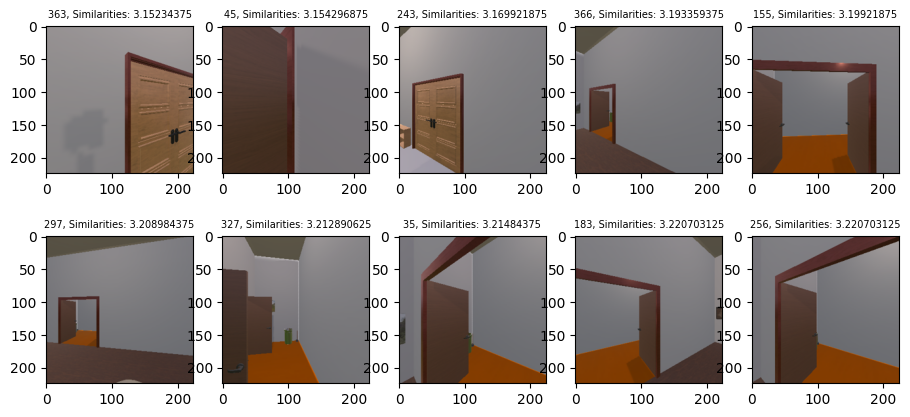

Mean similarities:  tensor(2.6426, device='mps:0', dtype=torch.float16, grad_fn=<MeanBackward0>)


In [56]:

text = clip.tokenize(["a door"]).to(device)
encoded_text = model.encode_text(text)
query = encoded_text

similarities = (embeddings @ query.T)  # shape (N,)
k = 10
topk_idx = similarities.argsort(dim=0)[-k-1:-1]
i = 1

plt.figure(figsize=(k + 1,5))
for idx in topk_idx:
    plt.subplot(2, int((k + 1) / 2), i)
    image, _ = dataset[idx]
    plt.imshow(denormalize(image))
    plt.title(str(idx.item()) + ", Similarities: " + str(similarities[idx].item()), fontsize=7)
    i += 1

plt.show()
print("Mean similarities: ", similarities.mean())


  Cloning https://github.com/openai/CLIP.git to /private/var/folders/0t/07s2_q6s70l396_6l3y94msh0000gn/T/pip-req-build-ok__tztk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/0t/07s2_q6s70l396_6l3y94msh0000gn/T/pip-req-build-ok__tztk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369549 sha256=dfcc6b484091019ab9a801b98c1dec9194000a942513a46d8d3d60804bea3e4c
  Stored in directory: /private/var/folders/0t/07s2_q6s70l396_6l3y94msh0000gn/T/pip-ephem-wheel-cache-chbfnk_6/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
